 # **Download & Extract Data**

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faridahelmy1","key":"257b5ea5585fea0d8baab715f7a3b02b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d olgabelitskaya/flower-color-images


Dataset URL: https://www.kaggle.com/datasets/olgabelitskaya/flower-color-images
License(s): other
  0% 0.00/50.1M [00:00<?, ?B/s]
100% 50.1M/50.1M [00:00<00:00, 1.12GB/s]


In [ ]:
!unzip -q flower-color-images.zip -d flower_data


# **Image processing**

In [ ]:
import numpy as np
import cv2
import glob
from tqdm import tqdm

image_paths = glob.glob("flower_data/flower_images/flower_images/*.png")
image_size = 64
X = []

for path in tqdm(image_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    X.append(img)

X = np.array(X)
X = (X.astype(np.float32) - 127.5) / 127.5  # تطبيع [-1,1]

import tensorflow as tf
BATCH_SIZE = 32
NOISE_DIM = 100
BUFFER_SIZE = X.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

100%|██████████| 210/210 [00:00<00:00, 451.04it/s]


# **Build Generator Model**

In [ ]:
from keras.layers import Input, Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Flatten, Activation
from keras.models import Model, Sequential
from keras.optimizers import Adam

img_shape = (image_size, image_size, 3)

In [ ]:
# Generator
def build_generator():
    input = Input(shape=(NOISE_DIM,))
    x = Dense(8*8*256, use_bias=False)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Reshape((8, 8, 256))(x)

    x = Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)

    return Model(inputs=input, outputs=x)

In [ ]:
build_generator().summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,363,139 (9.01 MB)

 Trainable params: 2,329,987 (8.89 MB)

 Non-trainable params: 33,152 (129.50 KB)

# **Build Discriminator Model**

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(Input(shape=img_shape))  # أول طبقة تعريف شكل الصورة

    model.add(Conv2D(32, 3, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(64, 3, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))

    model.add(Conv2D(128, 3, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))

    model.add(Conv2D(256, 3, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(1))
    return model


In [ ]:
build_discriminator().summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,305 (1.50 MB)

 Trainable params: 393,409 (1.50 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
generator = build_generator()
discriminator = build_discriminator()


# **Loss Func and Train_step**

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


# **View generated images**

In [ ]:
import matplotlib.pyplot as plt
import os
os.makedirs('generated_images', exist_ok=True)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2  # من [-1,1] إلى [0,1]

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
    plt.savefig(f'generated_images/image_at_epoch_{epoch:03d}.png')
    plt.close()

#**Training**

In [ ]:
import time
EPOCHS = 500
seed = tf.random.normal([16, NOISE_DIM])

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        generate_and_save_images(generator, epoch + 1, seed)
        print(f'Epoch {epoch+1} completed in {time.time()-start:.2f} sec')

    generate_and_save_images(generator, epochs, seed)

train(train_dataset, EPOCHS)

Epoch 1 completed in 5.97 sec
Epoch 2 completed in 4.50 sec
Epoch 3 completed in 4.73 sec
Epoch 4 completed in 5.47 sec
Epoch 5 completed in 4.55 sec
Epoch 6 completed in 5.58 sec
Epoch 7 completed in 4.59 sec
Epoch 8 completed in 4.53 sec
Epoch 9 completed in 5.78 sec
Epoch 10 completed in 4.57 sec
Epoch 11 completed in 4.81 sec
Epoch 12 completed in 6.32 sec
Epoch 13 completed in 5.34 sec
Epoch 14 completed in 6.75 sec
Epoch 15 completed in 5.40 sec
Epoch 16 completed in 6.69 sec
Epoch 17 completed in 5.30 sec
Epoch 18 completed in 7.08 sec
Epoch 19 completed in 6.99 sec
Epoch 20 completed in 5.88 sec
Epoch 21 completed in 5.96 sec
Epoch 22 completed in 5.40 sec
Epoch 23 completed in 6.61 sec
Epoch 24 completed in 5.28 sec
Epoch 25 completed in 6.60 sec
Epoch 26 completed in 5.32 sec
Epoch 27 completed in 5.80 sec
Epoch 28 completed in 6.12 sec
Epoch 29 completed in 5.27 sec
Epoch 30 completed in 6.61 sec
Epoch 31 completed in 5.33 sec
Epoch 32 completed in 6.56 sec
Epoch 33 complete

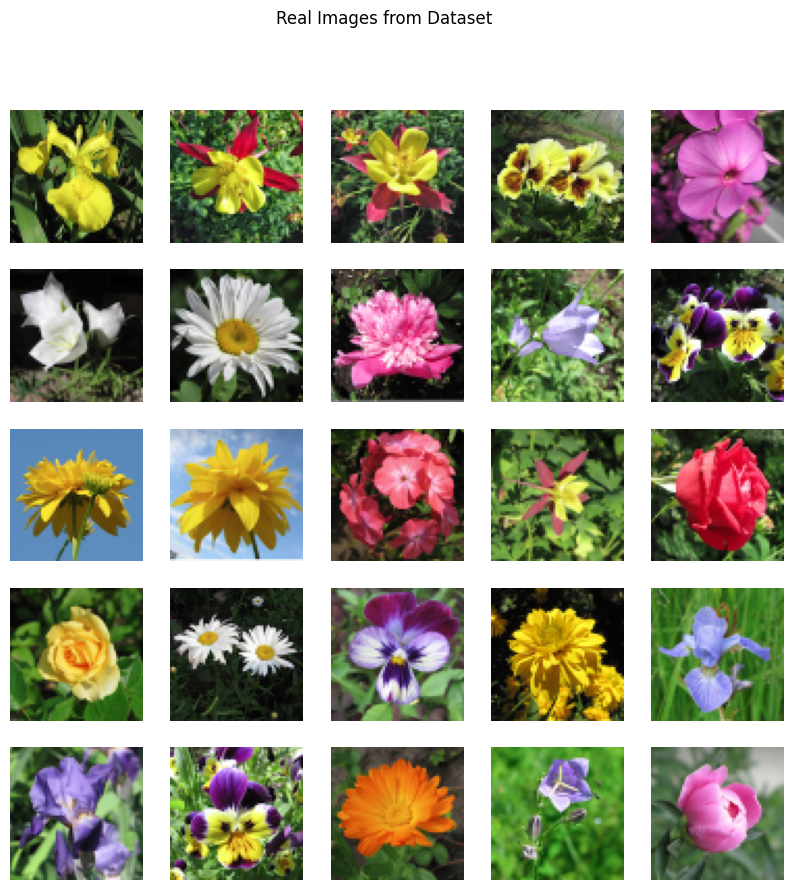

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load a batch of real images
for real_imgs in train_dataset.take(1):
  pass


# Plot some real images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow((real_imgs[i].numpy() + 1) / 2)
    plt.axis("off")
plt.suptitle("Real Images from Dataset")
plt.show()

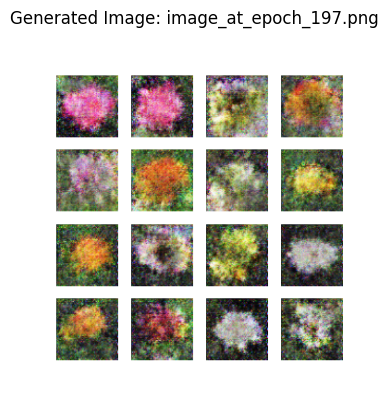

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

def show_random_generated_image(image_folder='generated_images'):
    # جمع كل الصور من المجلد
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

    if not image_files:
        print("❌ مفيش صور في المجلد.")
        return

    # اختيار صورة عشوائية
    chosen_image = random.choice(image_files)
    img_path = os.path.join(image_folder, chosen_image)

    # عرض الصورة
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated Image: {chosen_image}")
    plt.show()

# شغّل الدالة
show_random_generated_image()


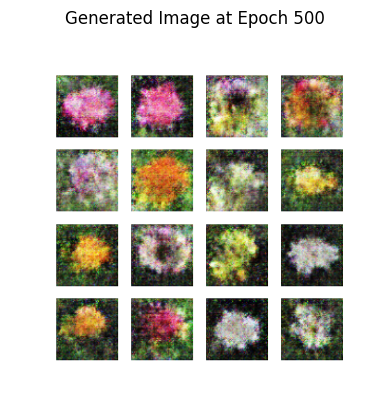

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def show_image_at_epoch(epoch_number, image_folder='generated_images'):
    file_name = f"image_at_epoch_{epoch_number:03d}.png"
    img_path = os.path.join(image_folder, file_name)

    if not os.path.exists(img_path):
        print(f"❌ الصورة {file_name} مش موجودة في {image_folder}")
        return

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated Image at Epoch {epoch_number}")
    plt.show()

# عرض صورة epoch 500
show_image_at_epoch(500)
